In [ ]:
#Random Forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished



Cross-Validation Results:
Average Accuracy: 0.9344 (±0.0037)
Average Precision: 0.9450 (±0.0062)
Average Recall: 0.9227 (±0.0112)
Average F1: 0.9336 (±0.0041)
Average ROC AUC: 0.9843 (±0.0010)

Aggregated Evaluation:
              precision    recall  f1-score   support

      Normal       0.92      0.95      0.94      8190
       Event       0.94      0.92      0.93      8192

    accuracy                           0.93     16382
   macro avg       0.93      0.93      0.93     16382
weighted avg       0.93      0.93      0.93     16382



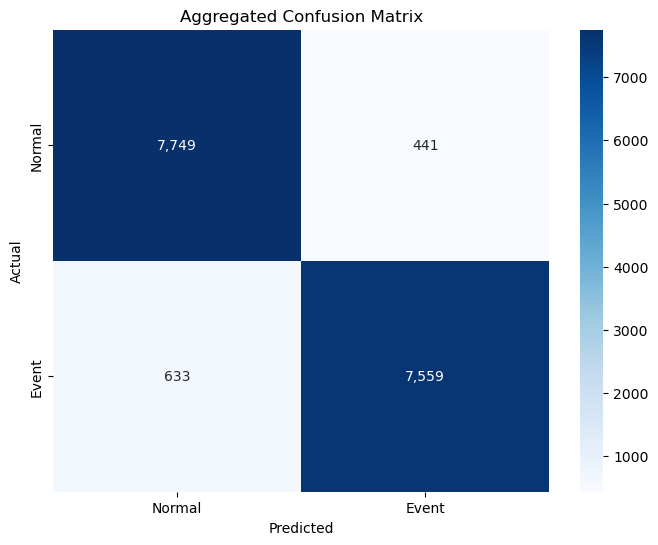

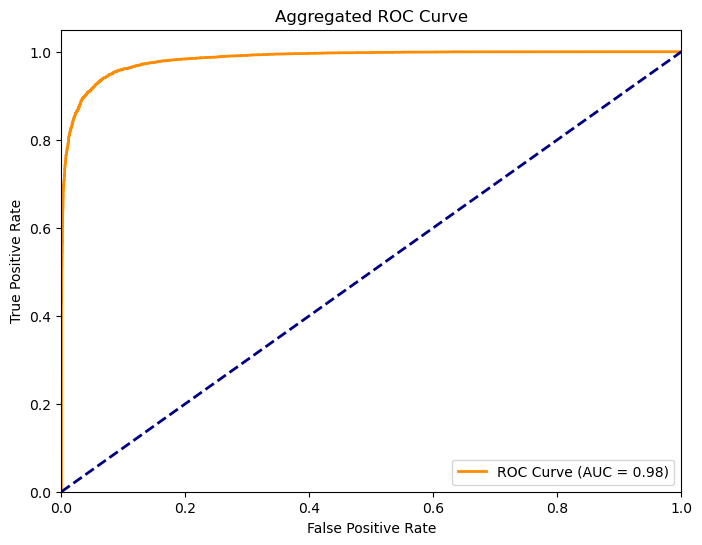

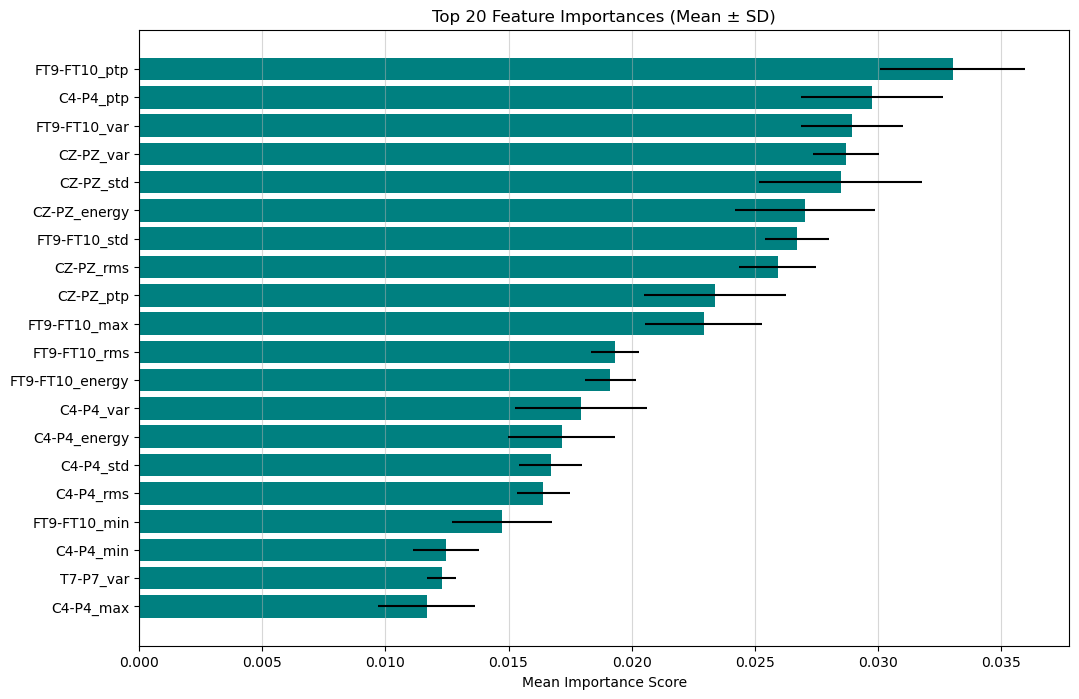

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# Load features
df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv').dropna()

# Configuration
N_SPLITS = 5
N_JOBS = -1
N_ESTIMATORS = 1000
RANDOM_STATE = None

# Prepare data
X = df.drop('target', axis=1)
y = df['target']
features = X.columns.tolist()

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Initialize metrics storage
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Storage for final aggregation
all_y_test = []
all_y_pred = []
all_y_proba = []
feature_importances = []

def process_fold(train_idx, test_idx, X, y):
    """Process one fold with full CPU utilization"""
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Class weights
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    weight_dict = {cls: w for cls, w in zip(classes, weights)}
    
    # Model training
    rf = RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=15,
        class_weight=weight_dict,
        n_jobs=N_JOBS,
        verbose=2,
        random_state=RANDOM_STATE,
        criterion='gini'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    return {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'importances': rf.feature_importances_
    }

# Parallel processing of folds
results = Parallel(n_jobs=min(N_SPLITS, N_JOBS), verbose=10)(
    delayed(process_fold)(train_idx, test_idx, X, y)
    for train_idx, test_idx in skf.split(X, y)
)

# Aggregate results
for result in results:
    all_y_test.extend(result['y_test'])
    all_y_pred.extend(result['y_pred'])
    all_y_proba.extend(result['y_proba'])
    feature_importances.append(result['importances'])
    
    # Calculate fold metrics
    metrics['accuracy'].append(accuracy_score(result['y_test'], result['y_pred']))
    metrics['precision'].append(precision_score(result['y_test'], result['y_pred']))
    metrics['recall'].append(recall_score(result['y_test'], result['y_pred']))
    metrics['f1'].append(f1_score(result['y_test'], result['y_pred']))
    metrics['roc_auc'].append(roc_auc_score(result['y_test'], result['y_proba']))

# Calculate average feature importances
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Print metrics
print("\nCross-Validation Results:")
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f} (±{np.std(metrics['accuracy']):.4f})")
print(f"Average Precision: {np.mean(metrics['precision']):.4f} (±{np.std(metrics['precision']):.4f})")
print(f"Average Recall: {np.mean(metrics['recall']):.4f} (±{np.std(metrics['recall']):.4f})")
print(f"Average F1: {np.mean(metrics['f1']):.4f} (±{np.std(metrics['f1']):.4f})")
print(f"Average ROC AUC: {np.mean(metrics['roc_auc']):.4f} (±{np.std(metrics['roc_auc']):.4f})")

# Final evaluation on all predictions
print("\nAggregated Evaluation:")
print(classification_report(all_y_test, all_y_pred, target_names=['Normal', 'Event']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Aggregated Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_score(all_y_test, all_y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
indices = np.argsort(mean_importances)[-20:]
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances (Mean ± SD)')
plt.barh(range(len(indices)), mean_importances[indices], xerr=std_importances[indices],
         align='center', color='teal', ecolor='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Mean Importance Score')
plt.grid(axis='x', alpha=0.5)
plt.show()

In [ ]:
#KNN

=== Best Model Test Set Performance ===
Accuracy: 0.9759

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1638
           1       0.98      0.97      0.98      1639

    accuracy                           0.98      3277
   macro avg       0.98      0.98      0.98      3277
weighted avg       0.98      0.98      0.98      3277


=== Cross-Validated Metrics ===
Average Accuracy: 0.9781 (±0.0024)
Average Precision: 0.9781
Average Recall: 0.9781
Average F1-Score: 0.9781

=== Optimal Hyperparameters ===
{'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}


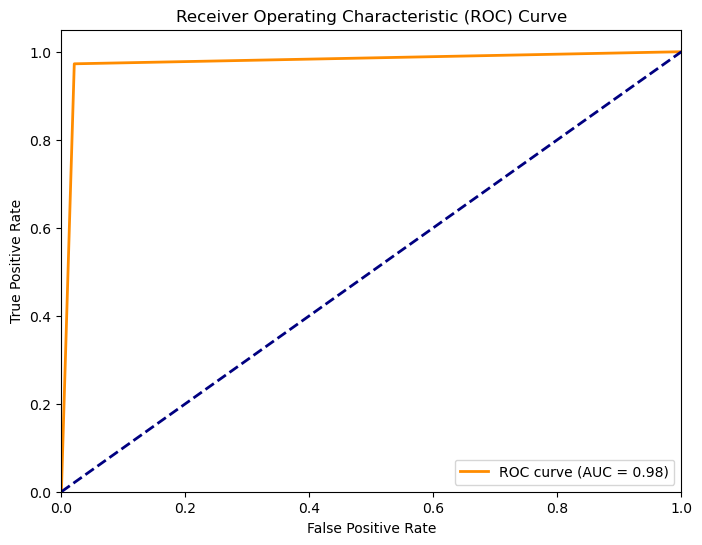

<Figure size 800x600 with 0 Axes>

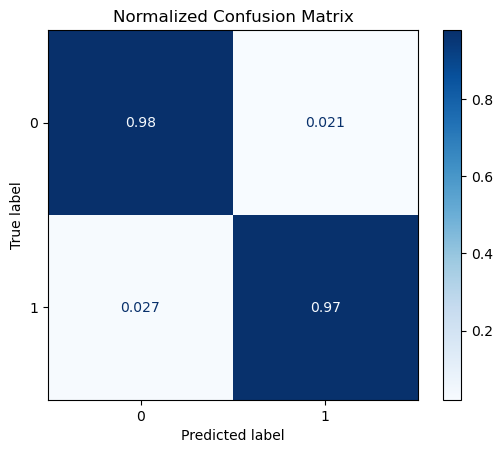

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Load dataset
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create processing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Crucial for KNN performance
    ('knn', KNeighborsClassifier(n_jobs=-1))  # Utilize all CPU cores
])

# Hyperparameter grid for tuning
param_grid = {
    'knn__n_neighbors': list(range(1, 10, 2)),  # Test various neighborhood sizes
    'knn__weights': ['uniform', 'distance'],  # Test weighting schemes
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
}

# Configure grid search with stratified k-fold
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring='accuracy',
    n_jobs=-1  # Utilize all CPU cores for parallel processing
)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Test set evaluation
y_pred = best_model.predict(X_test)
print("=== Best Model Test Set Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print(f"Average Accuracy: {cv_results['test_accuracy'].mean():.4f} (±{cv_results['test_accuracy'].std():.4f})")
print(f"Average Precision: {cv_results['test_precision_macro'].mean():.4f}")
print(f"Average Recall: {cv_results['test_recall_macro'].mean():.4f}")
print(f"Average F1-Score: {cv_results['test_f1_macro'].mean():.4f}")

# Display best parameters
print("\n=== Optimal Hyperparameters ===")
print(grid_search.best_params_)

y_proba = best_model.predict_proba(X_test)
n_classes = len(best_model.classes_)

# For binary classification
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test, y_test,
    display_labels=best_model.classes_,
    cmap=plt.cm.Blues,
    normalize='true'
)
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
#SVM

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score)

# -------------------------------
# Load your EEG time-domain features
# -------------------------------
# Assumes 'eeg_features.csv' has feature columns and a 'label' column.
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')

# Separate features and target labels
X = data.drop('target', axis=1)
y = data['target']

# -------------------------------
# Split data into training and testing sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# -------------------------------
# Set up Grid Search with K-Fold Cross Validation
# -------------------------------
# SVM with probability=True to enable ROC curve plotting
svc = SVC(probability=True, random_state=0)

# Define parameter grid: try various kernels and optionally adjust C and gamma.
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [10],
    'gamma': ['scale', 'auto']
}

# Using 5-fold cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid_search = GridSearchCV(svc, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters from GridSearchCV:")
print(grid_search.best_params_)

# -------------------------------
# Evaluate the Best Model on Test Set
# -------------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Set Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -------------------------------
# Plot Confusion Matrix using Seaborn
# -------------------------------
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# -------------------------------
# Plot ROC Curve
# -------------------------------
# For ROC curve, ensure a binary classification problem.
# For multi-class, consider one-vs-rest strategy.
if len(np.unique(y)) == 2:
    # Get probability estimates for the positive class.
    y_probs = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve plotting is implemented for binary classification. For multi-class, use a one-vs-rest strategy.")


KeyboardInterrupt: 

In [ ]:
#LGBM

In [5]:
!pip install lightgbm shap

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.3 MB/s eta 0:00:00


Fitting 3 folds for each of 32 candidates, totalling 96 fits
=== Advanced Metrics ===
Accuracy: 0.9561
Precision: 0.9611
Recall: 0.9506
F1 Score: 0.9558
ROC AUC: 0.9915

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1638
           1       0.96      0.95      0.96      1639

    accuracy                           0.96      3277
   macro avg       0.96      0.96      0.96      3277
weighted avg       0.96      0.96      0.96      3277



<Figure size 800x600 with 0 Axes>

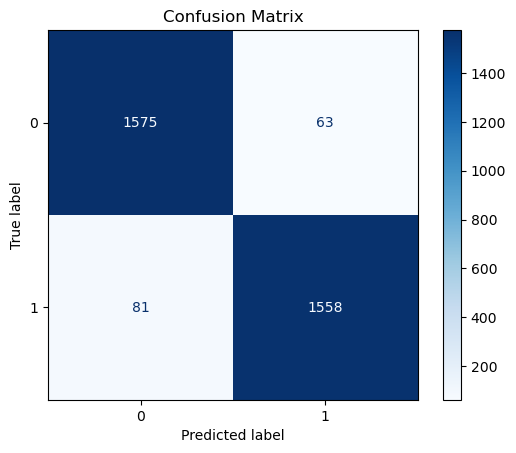

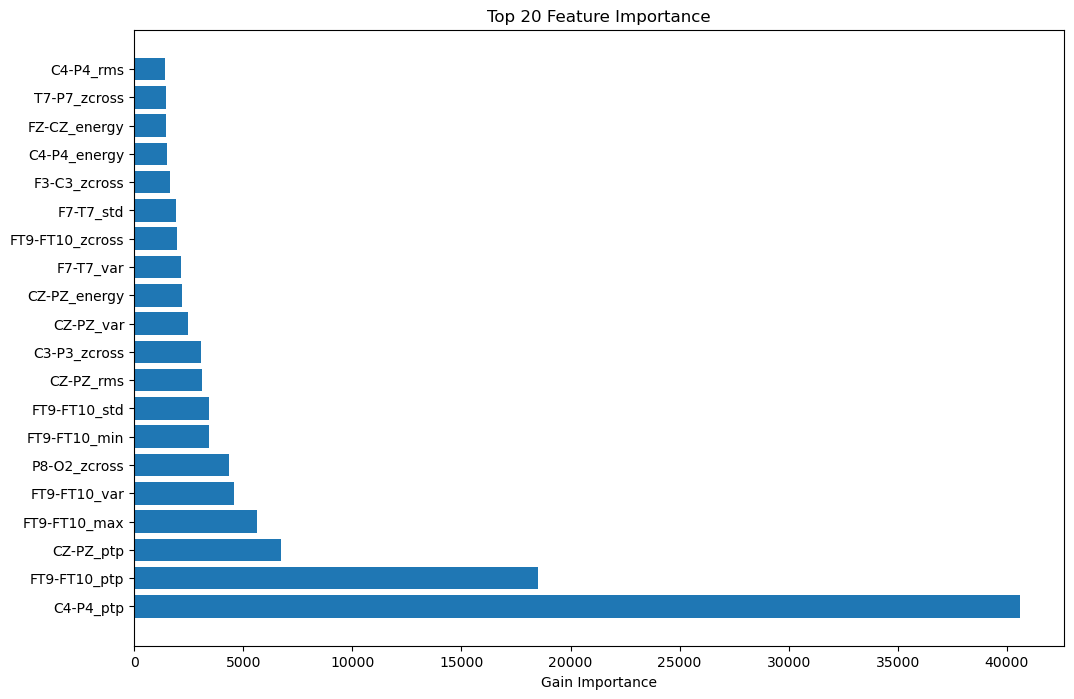

D:\MOOC.fi\Jupyter\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


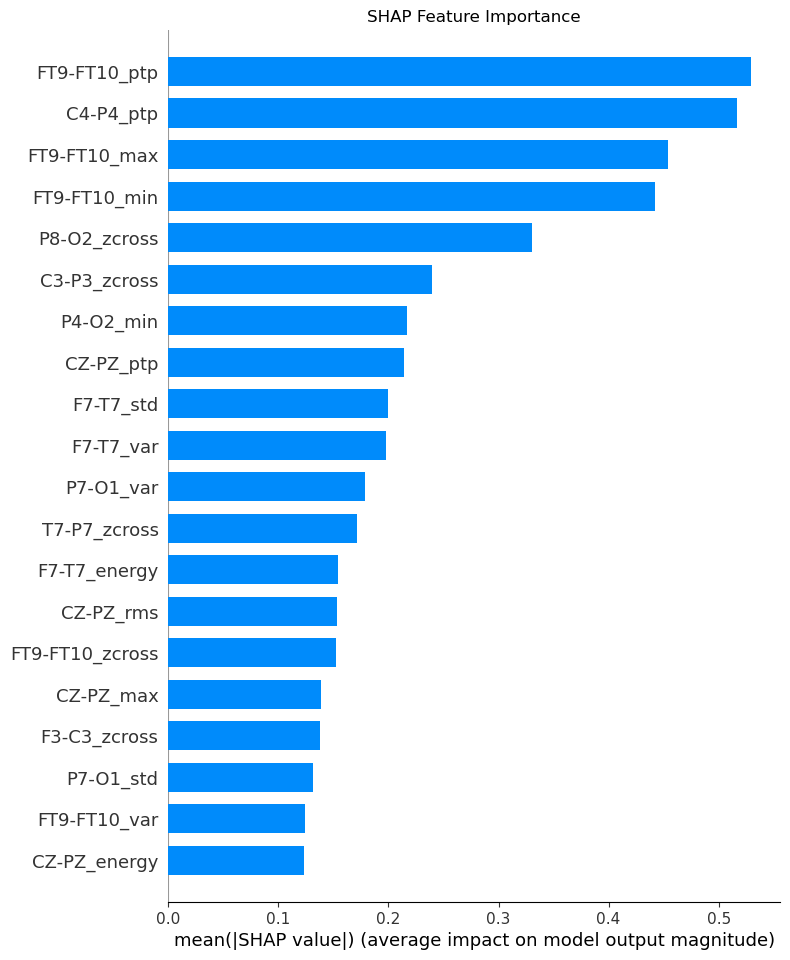

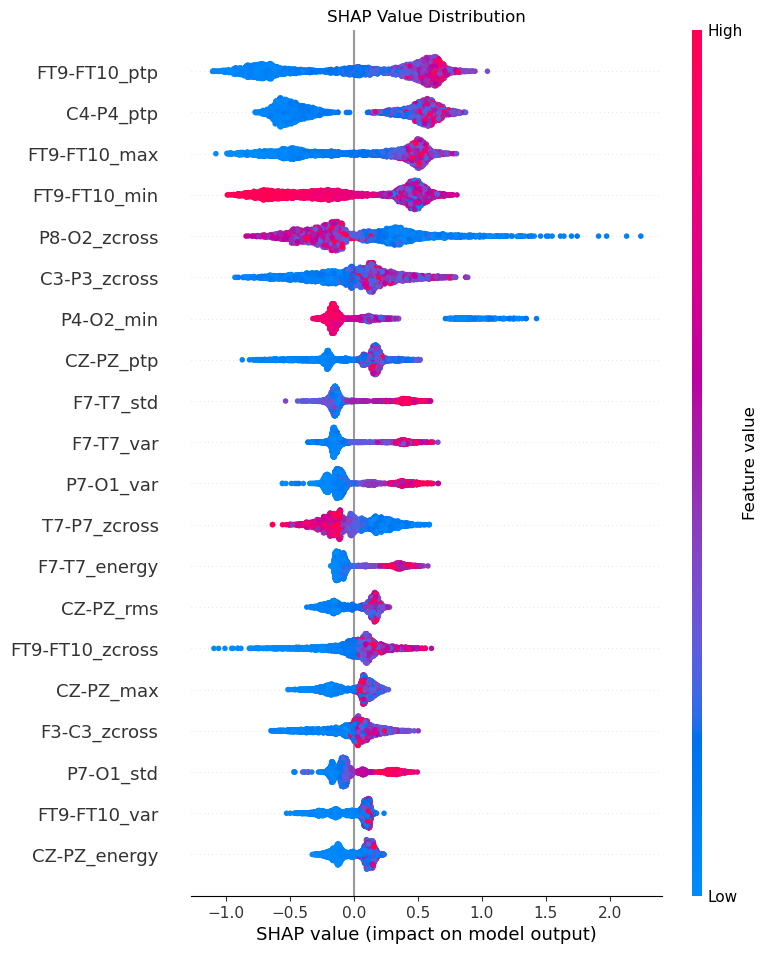

KeyError: 'training'

<Figure size 1200x600 with 0 Axes>

In [9]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Load data
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Advanced preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate class weights
classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Custom LightGBM dataset creation
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)

# Advanced parameter grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],  # Different boosting types
    'num_leaves': [63],        # Control tree complexity
    'max_depth': [ 7, 15],           # Limit tree depth
    'learning_rate': [ 0.05],
    'n_estimators': [200],
    'subsample': [0.8, 1.0],            # Stochastic gradient boosting
    'colsample_bytree': [0.8, 1.0],     # Feature fraction
    'reg_alpha': [0.1],           # L1 regularization
    'reg_lambda': [0.1],          # L2 regularization
    'min_child_samples': [20],      # Prevent overfitting
    'class_weight': [None, 'balanced'],
    'device': ['gpu']
}

# Advanced model configuration
model = lgb.LGBMClassifier(
    objective='binary',  # Change for multiclass
    metric='binary_logloss',
    boosting_type='gbdt',
    importance_type='gain',
    device='gpu',
    n_jobs=-1,
    verbose=-1
)

# Nested cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter optimization
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Advanced evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("=== Advanced Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return y_proba

# Feature Importance Visualization
def plot_feature_importance(model, features):
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'][:20], importance['Importance'][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Gain Importance')
    plt.show()

# SHAP Value Analysis
def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # If binary classification, shap_values will be a list with two arrays
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]  # Use the SHAP values for the positive class
    
    # SHAP Feature Importance (Bar Plot)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.show()
    
    # SHAP Value Distribution (Summary Plot)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Value Distribution')
    plt.show()


# Learning Curve Analysis
def plot_learning_curve(model, X, y):
    results = model.evals_result_
    plt.figure(figsize=(12, 6))
    plt.plot(results['training']['binary_logloss'], label='Train')
    plt.plot(results['validation']['binary_logloss'], label='Validation')
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.show()

# Execute evaluation
y_proba = evaluate_model(best_model, X_test, y_test)
plot_feature_importance(best_model, X.columns)
shap_analysis(best_model, X_test)
plot_learning_curve(best_model, X_train, y_train)

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv_results = cross_validate(
    best_model,
    X, y,
    cv=outer_cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
print(f"Average Training Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
print("\nTraining vs Validation Scores:")
print(pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train ROC AUC': cv_results['train_roc_auc'],
    'Val ROC AUC': cv_results['test_roc_auc']
}))

In [ ]:
#HGB

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Load data
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Advanced train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Advanced parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 300],
    'max_depth': [3, 7, None],
    'max_leaf_nodes': [15, 31],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1],
    'max_bins': [128],
    'scoring': ['loss', 'accuracy'],
    'early_stopping': [True]
}

# Advanced model configuration
model = HistGradientBoostingClassifier(
    class_weight='balanced',
    random_state=42,
    verbose=1,
    n_iter_no_change=10,
    validation_fraction=0.1
)

# Nested cross-validation setup
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter optimization
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Advanced evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("=== Advanced Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_proba

# Feature Importance Analysis
def plot_feature_importance(model, features):
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'][:20], importance['Importance'][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Gain Importance')
    plt.show()
    
    # Permutation Importance
    result = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10, 
        random_state=42,
        n_jobs=-1
    )
    
    perm_importance = pd.DataFrame({
        'Feature': features,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(perm_importance['Feature'][:20], perm_importance['Importance'][:20],
             xerr=perm_importance['Std'][:20])
    plt.title('Top 20 Permutation Importance')
    plt.xlabel('Mean Accuracy Decrease')
    plt.show()

# Learning Curve Analysis
def plot_learning_curve(model):
    train_scores = model.train_score_
    validation_scores = model.validation_score_
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_scores, label='Train')
    plt.plot(validation_scores, label='Validation')
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

# Execute evaluation
y_proba = evaluate_model(best_model, X_test, y_test)
plot_feature_importance(best_model, X.columns)
plot_learning_curve(best_model)

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv_results = cross_validate(
    best_model,
    X, y,
    cv=outer_cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
print(f"Average Training Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
print("\nTraining vs Validation Scores:")
print(pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train ROC AUC': cv_results['train_roc_auc'],
    'Val ROC AUC': cv_results['test_roc_auc']
}))

Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [ ]:
#XGBOOST

In [11]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.9 MB/s eta 0:01:21
   ---------------------------------------- 1.0/150.0 MB 2.0 MB/s eta 0:01:15
   ---------------------------------------- 1.6/150.0 MB 2.2 MB/s eta 0:01:08
    --------------------------------------- 2.4/150.0 MB 2.6 MB/s eta 0:00:58
    --------------------------------------- 3.1/150.0 MB 2.8 MB/s eta 0:00:52
   - -------------------------------------- 3.9/150.0 MB 3.1 MB/s eta 0:00:48
   - -------------------------------------- 5.2/150.0 MB 3.5 MB/s eta 0:00:42
   - -------------------------------------- 6.6/150.0 MB 3.8 MB/s eta 0:00:38
   -- ------------------------------------- 8.1/150.0 MB 4.2 MB/s eta 0:00:34
   -- ------------------------------------- 10.0/150.0 MB 4.7 MB/s eta 0:00:30
   --- ------------------------------------ 12.8/150.0 MB 5.6 MB/s eta 0:00:2

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Load data
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Advanced parameter grid
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__max_depth': [3, 6, 9],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.3],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [0, 0.1, 1],
    'xgb__scale_pos_weight': [1, None],  # For class imbalance
    'xgb__tree_method': ['gpu_hist'],  # GPU acceleration
    'xgb__predictor': ['gpu_predictor']
}

# Create pipeline with optional scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional but sometimes helpful
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=1000,  # Use early stopping
        early_stopping_rounds=50,
        random_state=42
    ))
])

# Advanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train, xgb__eval_set=[(X_test, y_test)])
best_model = grid_search.best_estimator_

# Advanced evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("=== Advanced Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_proba

# Feature Importance Visualization
def plot_feature_importance(model):
    xgb_feat_imp = model.named_steps['xgb'].feature_importances_
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_feat_imp
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'][:20], importance['Importance'][:20])
    plt.title('Top 20 XGBoost Feature Importance (Gain)')
    plt.xlabel('Importance Score')
    plt.show()

# SHAP Explainability
def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model.named_steps['xgb'])
    X_processed = model.named_steps['scaler'].transform(X) if 'scaler' in model.named_steps else X
    shap_values = explainer.shap_values(X_processed)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Value Distribution')
    plt.show()

# Learning Curve
def plot_learning_curve(model):
    results = model.named_steps['xgb'].evals_result()
    plt.figure(figsize=(12, 6))
    plt.plot(results['validation_0']['logloss'], label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Execute evaluation
y_proba = evaluate_model(best_model, X_test, y_test)
plot_feature_importance(best_model)
shap_analysis(best_model, X_test)
plot_learning_curve(best_model)

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
print("\nTraining vs Validation Scores:")
print(pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train ROC AUC': cv_results['train_roc_auc'],
    'Val ROC AUC': cv_results['test_roc_auc']
}))

In [ ]:
#1D-CNN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('your_dataset.csv')
# Assuming the 23 EEG channels are the first 23 columns and the last column is Outcome
channels = data.columns[:-1]
labels = data.columns[-1]

# Convert data to numpy arrays
eeg_data = data[channels].values   # shape: (n_samples, 23)
eeg_labels = data[labels].values     # shape: (n_samples,)

# Define window parameters
window_size = 256  # Number of time steps per window (1 second at 256Hz)
n_channels = 23

# Ensure that the total number of rows is a multiple of window_size
n_total = eeg_data.shape[0]
n_windows = n_total // window_size
eeg_data = eeg_data[:n_windows * window_size]
eeg_labels = eeg_labels[:n_windows * window_size]

# Reshape data into windows: (n_windows, window_size, n_channels)
X_reshaped = eeg_data.reshape(n_windows, window_size, n_channels)

# For the label of each window, you can choose the mode, maximum, or any aggregation rule.
# Here, we'll label a window as '1' if any time point in that window is labeled as seizure.
y_window = np.array([1 if np.any(window == 1) else 0 for window in eeg_labels.reshape(n_windows, window_size)])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_window, test_size=0.2, stratify=y_window, random_state=42
)

# Build the model using the Functional API (to facilitate the attention block)
inp = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

# Temporal convolution block
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inp)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Spatial-temporal processing
x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Channel-wise attention block:
attn = layers.Conv1D(128, kernel_size=1, activation='relu')(x)
attn = layers.Attention()([attn, attn])
x = layers.Add()([x, attn])

# Deep feature extraction
x = layers.Conv1D(256, kernel_size=3, activation='relu', padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)

# Classification head
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

# Compute class weights to account for any imbalance in seizure vs. non-seizure windows
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights
)

# Evaluation
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Learning Curves for AUC and Loss
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Learning Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve')
plt.legend()
plt.show()
